# 2D decaying turbulence


A simulation of decaying two-dimensional turbulence.

In [1]:
using Pkg; Pkg.activate("../."); Pkg.instantiate();

 Activating environment at `~/Teaching/CLExWinterSchool2020/Project.toml`


In [2]:
using FourierFlows, Plots, Printf, Random

using FFTW: irfft
using Random: seed!

import GeophysicalFlows.TwoDNavierStokes
import GeophysicalFlows.TwoDNavierStokes: energy, enstrophy
import GeophysicalFlows: peakedisotropicspectrum

## Numerical parameters and time-stepping parameters

In [3]:
     nx = 256            # 2D resolution = nx^2
stepper = "FilteredRK4"  # timestepper
     dt = 0.005          # timestep
 nsteps = 8000           # total number of time-steps
 nsubs  = 20;            # number of time-steps for intermediate logging/plotting (nsteps must be multiple of nsubs)

## Physical parameters

In [4]:
Lx = 2π;       # domain size

## Problem setup
We initialize a `Problem` by providing a set of keyword arguments. Not providing
a viscosity coefficient ν leads to the module's default value: `ν=0`. In this
example numerical instability due to accumulation of enstrophy in high wavenumbers
is taken care with the `FilteredTimestepper` we picked.

In [5]:
prob = TwoDNavierStokes.Problem(nx=nx, Lx=Lx, dt=dt, stepper=stepper);

and define some shortcuts

In [6]:
sol, cl, vs, pr, gr = prob.sol, prob.clock, prob.vars, prob.params, prob.grid
x, y = gr.x, gr.y;

## Diagnostics

Create Diagnostics -- `energy` and `enstrophy` functions are imported at the top.

In [7]:
E = Diagnostic(energy, prob; nsteps=nsteps)
Z = Diagnostic(enstrophy, prob; nsteps=nsteps)
diags = [E, Z]; # A list of Diagnostics types passed to "stepforward!" will  be updated every timestep.

## Visualizing the simulation

We define a function that plots the vorticity and streamfunction fields and
their corresponding zonal mean structure.

In [8]:
function plot_output(prob)
  Lx, Ly = prob.grid.Lx, prob.grid.Ly
    
  p1 = heatmap(x, y, vs.zeta,
             aspectratio = 1,
                       c = :balance,
                    clim = (-20, 20),
                   xlims = (-Lx/2, Ly/2),
                   ylims = (-Lx/2, Ly/2),
                  xticks = -3:3,
                  yticks = -3:3,
                  xlabel = "x",
                  ylabel = "y",
                   title = "vorticity, t="*@sprintf("%.2f", cl.t),
              framestyle = :box)

  p2 = plot(2, # this means "a plot with two series"
                   label = ["energy E(t)/E(0)" "enstrophy Z(t)/Z(0)"],
                  legend = :right,
               linewidth = 2,
                   alpha = 0.7,
                  xlabel = "t",
                   xlims = (0, 41),
                   ylims = (0, 1.1))

  l = @layout grid(1, 2)
  p = plot(p1, p2, layout = l, size = (900, 400))
  return p
end;

## Setting initial conditions

Our initial condition consist of a flow that has power only at wavenumbers with
$8<\frac{L}{2\pi}\sqrt{k_x^2+k_y^2}<10$ and initial energy $E_0$:

In [9]:
Random.seed!(1234)

k₀ = 6   # central total wavenumber of initial condition 
E₀ = 0.5 # energy of initial condition

q₀ = peakedisotropicspectrum(gr, k₀, E₀, mask=prob.timestepper.filter);

Let's initialize our problem with this initial condition...

In [10]:
TwoDNavierStokes.set_zeta!(prob, q₀);

and let's plot it to see how it looks.

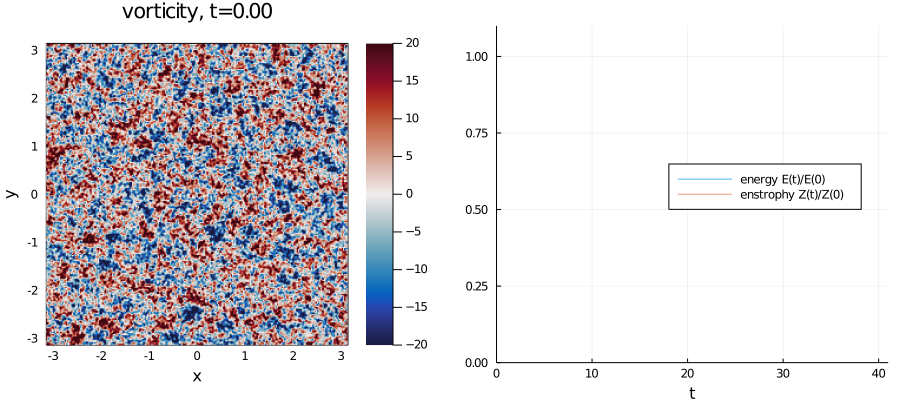

In [11]:
plot_output(prob)

## Time-stepping the `Problem` forward

We time-step the `Problem` forward in time. Every `nsubs` time-steps we update the plot and create an animation.

In [27]:
startwalltime = time()

p = plot_output(prob)

anim = @animate for j=0:Int(nsteps/nsubs)

  log = @sprintf("step: %04d, t: %d, walltime: %.2f min", cl.step, cl.t, (time()-startwalltime)/60)

  if j%(1000/nsubs)==0; println(log) end  
  
  # Update the subplots in the plot and their corresponding titles
  p[1][1][:z] = vs.zeta
  p[1][:title] = "vorticity, t="*@sprintf("%.2f", cl.t)
  push!(p[2][1], E.t[E.i], E.data[E.i]/E.data[1])
  push!(p[2][2], Z.t[Z.i], Z.data[Z.i]/Z.data[1])

  stepforward!(prob, diags, nsubs)
  TwoDNavierStokes.updatevars!(prob)
    
end

mp4(anim, "twodturb_decay.mp4", fps=24)

step: 0000, t: 0, walltime: 0.00 min
step: 1000, t: 5, walltime: 0.39 min
step: 2000, t: 10, walltime: 0.75 min
step: 3000, t: 15, walltime: 1.12 min
step: 4000, t: 20, walltime: 1.49 min
step: 5000, t: 25, walltime: 1.86 min
step: 6000, t: 30, walltime: 2.25 min
step: 7000, t: 35, walltime: 2.63 min
step: 8000, t: 40, walltime: 3.01 min


┌ Info: Saved animation to 
│   fn = /Users/navid/Teaching/CLExWinterSchool2020/simulations/twodturb_decay.mp4
└ @ Plots /Users/navid/.julia/packages/Plots/mXrnb/src/animation.jl:104


Plots.AnimatedGif("/Users/navid/Teaching/CLExWinterSchool2020/simulations/twodturb_decay.mp4")